<a href="https://colab.research.google.com/github/solobala/DLL30/blob/main/DLL30_DZ10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Компьютерное зрение-2

Обучить U-Net сегментировать сгенерированные кружочки.
Код для генерации
[здесь](https://colab.research.google.com/drive/1Fum-Udmayf60qfJAl4N5z8hgUH6_uoTc/)

# Импорт библиотек

In [1]:
import numpy as np
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import copy
from tqdm.notebook import tqdm

In [3]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Функции и классы

In [5]:
# Базовый класс для генерации датасета
class BaseDataProvider(object):
    channels = 1
    n_class = 2 # для каждого пикселя - один из 2 классов (это кружок или не кружок(прямоугольник))

    def __init__(self, a_min=None, a_max=None):
        self.a_min = a_min if a_min is not None else -np.inf
        self.a_max = a_max if a_min is not None else np.inf

    def _load_data_and_label(self):
        data, label = self._next_data()

        train_data = self._process_data(data) # данные для обучения нормализуют
        labels = self._process_labels(label)

        train_data, labels = self._post_process(train_data, labels) # опция для аугментации, здесь не используется

        nx = train_data.shape[1]
        ny = train_data.shape[0]

        return train_data.reshape(1, ny, nx, self.channels), labels.reshape(1, ny, nx, self.n_class),

    def _process_labels(self, label):
        if self.n_class == 2:
            nx = label.shape[1]
            ny = label.shape[0]
            labels = np.zeros((ny, nx, self.n_class), dtype=np.float32)

            # It is the responsibility of the child class to make sure that the label
            # is a boolean array, but we a chech here just in case.
            if label.dtype != 'bool':
                label = label.astype(np.bool)

            labels[..., 1] = label
            labels[..., 0] = ~label
            return labels

        return label

    def _process_data(self, data):
        # normalization - переводит элементы в data в диапазон от a_min до a_max
        data = np.clip(np.fabs(data), self.a_min, self.a_max)
        data -= np.amin(data) # вычитает из каждого элемента a_min

        if np.amax(data) != 0:
            data /= np.amax(data) # и делит на a_max

        return data

    def _post_process(self, data, labels):
        """
        Post processing hook that can be used for data augmentation
        :param data: the data array
        :param labels: the label array
        """
        return data, labels

    def __call__(self, n):
        train_data, labels = self._load_data_and_label()
        nx = train_data.shape[1]
        ny = train_data.shape[2]

        X = np.zeros((n, nx, ny, self.channels))
        Y = np.zeros((n, nx, ny, self.n_class))

        X[0] = train_data
        Y[0] = labels
        for i in range(1, n):
            train_data, labels = self._load_data_and_label()
            X[i] = train_data
            Y[i] = labels

        return X, Y

In [6]:
def create_image_and_label(nx,ny, cnt = 10, r_min = 5, r_max = 25, border = 23, sigma = 20, rectangles=False):
    """Эта функция создает изображение и метки для использования в задачах компьютерного зрения.

Аргументы функции:
- nx и ny - ширина и высота изображения;
- cnt - количество кругов, которые будут нарисованы на изображении;
- r_min и r_max - минимальный и максимальный радиусы кругов;
- border - расстояние от края изображения, до области, где могут быть нарисованы круги;
- sigma - уровень шума в изображении;
- rectangles - логический флаг, указывающий, нужно ли добавлять на изображение прямоугольники.

Функция создает пустое изображение и метки, затем рисует случайное количество
кругов на изображении с помощью случайно выбранных координат центра, радиуса и яркости.
Затем функция добавляет шум к изображению и нормализует его значения в диапазоне от 0 до 1.

Если флаг rectangles установлен в True, то функция также нарисует случайное количество
прямоугольников на изображении с помощью случайно выбранных координат левого верхнего угла,
размера и яркости. Затем функция обновит метки, чтобы отразить наличие кругов и прямоугольников на изображении.

Функция возвращает изображение и метки в зависимости от значения флага rectangles.
Если флаг установлен в True, то возвращается кортеж (image, label),
где label - это трехканальная метка, где первый канал указывает на отсутствие объектов,
второй - на присутствие кругов, а третий - на присутствие прямоугольников.
Если флаг rectangles установлен в False, то возвращается кортеж (image, label),
где label - это двухканальная метка, где первый канал указывает на отсутствие объектов,
а второй - на присутствие кругов."""

    image = np.ones((nx, ny, 1))
    label = np.zeros((nx, ny, 3), dtype=np.bool)
    mask = np.zeros((nx, ny), dtype=np.bool)

    for _ in range(cnt):
        a = np.random.randint(border, nx-border) # Координата Х центра круга
        b = np.random.randint(border, ny-border) # Координата Y центра круга
        r = np.random.randint(r_min, r_max) # Радиус круга
        h = np.random.randint(1,255) # оттенок серого

        y,x = np.ogrid[-a:nx-a, -b:ny-b]
        m = x*x + y*y <= r*r # Условие, чтобы объект был кругом
        mask = np.logical_or(mask, m)

        image[m] = h

    label[mask, 1] = 1

    if rectangles:
        mask = np.zeros((nx, ny), dtype=np.bool)
        for _ in range(cnt//2):
            a = np.random.randint(nx)
            b = np.random.randint(ny)
            r =  np.random.randint(r_min, r_max)
            h = np.random.randint(1,255)

            m = np.zeros((nx, ny), dtype=np.bool)
            m[a:a+r, b:b+r] = True
            mask = np.logical_or(mask, m)
            image[m] = h

        label[mask, 2] = 1

        label[..., 0] = ~(np.logical_or(label[...,1], label[...,2]))

    image += np.random.normal(scale=sigma, size=image.shape)
    image -= np.amin(image)
    image /= np.amax(image)

    if rectangles:
        return image, label
    else:
        return image, label[..., 1]

In [51]:
def showPlot(points1, points2, n_iters, print_every, title):
    """Визуализация обучения"""
    fig = plt.figure(figsize=(4,2))
    ax = fig.add_subplot(1, 1, 1)
    xdata = [i * print_every for i in range(len(points1))]
    ax.plot(xdata, points1, color='tab:blue')
    ax.plot(xdata, points2, color='tab:orange')
    ax.set_title(title)
    plt.show()

In [7]:
def to_rgb(img):
    """Данная функция преобразует одноканальное изображение в трехканальное
    RGB изображение с помощью цветовой схемы, называемой "jet colormap".

Аргумент функции:
- img - массив с одним каналом, представляющий изображение.

Функция начинается с преобразования массива img в двумерный массив,
игнорируя любые значения NaN. Затем массив нормализуется таким образом,
чтобы его значения находились в диапазоне от 0 до 1.

Далее функция использует цветовую схему "jet colormap",
которая присваивает красный цвет значениям, большим 0.25,
зеленый цвет - значениям, близким к 0.5, и синий цвет - значениям, меньшим 0.75.
Эта схема позволяет легко визуализировать различные значения на изображении.

Наконец, функция объединяет три цветовых канала в одно RGB изображение и возвращает его."""
    img = img.reshape(img.shape[0], img.shape[1])
    img[np.isnan(img)] = 0
    img -= np.amin(img)
    img /= np.amax(img)
    blue = np.clip(4*(0.75-img), 0, 1)
    red  = np.clip(4*(img-0.25), 0, 1)
    green= np.clip(44*np.fabs(img-0.5)-1., 0, 1)
    rgb = np.stack((red, green, blue), axis=2)
    return rgb


In [8]:
# Класс для генерации кружков в оттенках серого. Расширили базовый класс путем добавления ** kwargs
# Нужно для того, чтобы и прямоугольники генерить, если требуется
class GrayScaleDataProvider(BaseDataProvider):
    channels = 1
    n_class = 2

    def __init__(self, nx, ny, **kwargs):
        super(GrayScaleDataProvider, self).__init__()
        self.nx = nx
        self.ny = ny
        self.kwargs = kwargs
        rect = kwargs.get("rectangles", False)
        if rect:
            self.n_class=3

    def _next_data(self):
        return create_image_and_label(self.nx, self.ny, **self.kwargs)

In [9]:
# Класс для генерации RGB кружков (и прямоугольников при необходимости)
class RgbDataProvider(BaseDataProvider):
    channels = 3
    n_class = 2

    def __init__(self, nx, ny, **kwargs):
        super(RgbDataProvider, self).__init__()
        self.nx = nx
        self.ny = ny
        self.kwargs = kwargs
        rect = kwargs.get("rectangles", False)
        if rect:
            self.n_class=3


    def _next_data(self):
        data, label = create_image_and_label(self.nx, self.ny, **self.kwargs)
        return to_rgb(data), label

In [25]:
class param:
    nx = 576
    ny = 576
    lr = 0.00001
    unet_depth = 5
    unet_start_filters = 8
    epochs = 5000
    log_interval = 100

Если работать с исходными данными в оттенках серого (одноканальное изображение), то для перевода в 3 каналп потребуется функция to_rgb()

In [11]:
generator = GrayScaleDataProvider(param.nx, param.ny, cnt=20)

In [12]:
x_test, y_test = generator(1)

In [13]:
x_test[0].shape

(576, 576, 1)

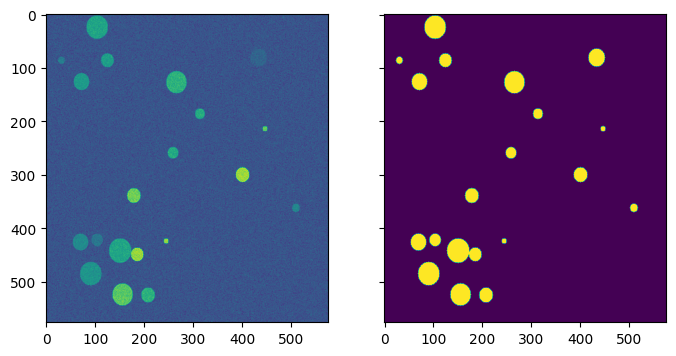

In [14]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(8,4))
ax[0].imshow(x_test[0,...,0], aspect="auto")
ax[1].imshow(y_test[0,...,1], aspect="auto")


In [15]:
y_test[0,...,1]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

генератор RgbDataProvider сразу выдает 3-канальные изображения и маски для них

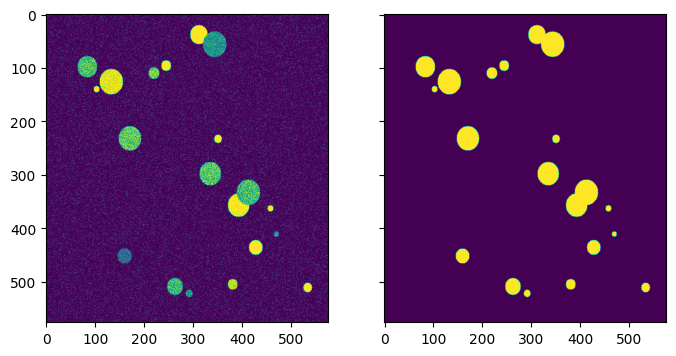

In [17]:
generator = RgbDataProvider(param.nx, param.ny, cnt=20)

x_test, y_test = generator(1)

fig, ax = plt.subplots(1,2, sharey=True, figsize=(8,4))
ax[0].imshow(x_test[0,...,0], aspect="auto")
ax[1].imshow(y_test[0,...,1], aspect="auto")

# Модель U-Net

In [18]:
# Вспомогательные блоки для конволюции и пулинга
def conv1x1(in_channels, out_channels, groups=1):
    return nn.Conv2d(in_channels,
                     out_channels,
                     kernel_size=1,
                     groups=groups,
                     stride=1)

def conv3x3(in_channels, out_channels, stride=1, padding=1, bias=True, groups=1):
    return nn.Conv2d(in_channels,
                     out_channels,
                     kernel_size=3,
                     stride=stride,
                     padding=padding,
                     bias=bias,
                     groups=groups)

def upconv2x2(in_channels, out_channels, mode='transpose'):
    if mode == 'transpose':
        return nn.ConvTranspose2d(in_channels,
                                  out_channels,
                                  kernel_size=2,
                                  stride=2)
    else:
        return nn.Sequential(
            nn.Upsample(mode='bilinear', scale_factor=2),
            conv1x1(in_channels, out_channels))

In [19]:
# Блок сжатия
class DownConv(nn.Module):
    """
    A helper Module that performs 2 convolutions and 1 MaxPool.
    A ReLU activation follows each convolution.
    """
    def __init__(self, in_channels, out_channels, pooling=True):
        super(DownConv, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.pooling = pooling

        self.conv1 = conv3x3(self.in_channels, self.out_channels)
        self.conv2 = conv3x3(self.out_channels, self.out_channels)

        if self.pooling:
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        # print('на входе',x.shape)
        x = F.relu(self.conv1(x))
        # print('1 conv', x.shape)
        x = F.relu(self.conv2(x))
        # print('2 conv', x.shape)
        before_pool = x
        if self.pooling:
            x = self.pool(x)
        # print(x.shape, before_pool.shape)
        return x, before_pool

In [20]:
# Блок расширения
class UpConv(nn.Module):
    """
    A helper Module that performs 2 convolutions and 1 UpConvolution.
    A ReLU activation follows each convolution.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 merge_mode='concat',
                 up_mode='transpose'):
        super(UpConv, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.merge_mode = merge_mode
        self.up_mode = up_mode

        self.upconv = upconv2x2(self.in_channels,
                                self.out_channels,
                                mode=self.up_mode)

        if self.merge_mode == 'concat':
            self.conv1 = conv3x3(2*self.out_channels,
                                 self.out_channels)
        else:
            # num of input channels to conv2 is same
            self.conv1 = conv3x3(self.out_channels, self.out_channels)

        self.conv2 = conv3x3(self.out_channels, self.out_channels)

    def forward(self, from_down, from_up):
        """ Forward pass
        Arguments:
            from_down: tensor from the encoder pathway
            from_up: upconv'd tensor from the decoder pathway
        """
        # print(from_up.shape)
        from_up = self.upconv(from_up)
        # print(from_up.shape)
        if self.merge_mode == 'concat':
            x = torch.cat((from_up, from_down), 1)
        else:
            x = from_up + from_down
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return x

In [21]:
class UNet(nn.Module):
    """ `UNet` class is based on https://arxiv.org/abs/1505.04597
    The U-Net is a convolutional encoder-decoder neural network.
    Contextual spatial information (from the decoding,
    expansive pathway) about an input tensor is merged with
    information representing the localization of details
    (from the encoding, compressive pathway).
    Modifications to the original paper:
    (1) padding is used in 3x3 convolutions to prevent loss
        of border pixels
    (2) merging outputs does not require cropping due to (1)
    (3) residual connections can be used by specifying
        UNet(merge_mode='add')
    (4) if non-parametric upsampling is used in the decoder
        pathway (specified by upmode='upsample'), then an
        additional 1x1 2d convolution occurs after upsampling
        to reduce channel dimensionality by a factor of 2.
        This channel halving happens with the convolution in
        the tranpose convolution (specified by upmode='transpose')
    """

    def __init__(self, num_classes, in_channels=3, depth=5,
                 start_filts=64, up_mode='transpose',
                 merge_mode='concat'):
        """
        Arguments:
            in_channels: int, number of channels in the input tensor.
                Default is 3 for RGB images.
            depth: int, number of MaxPools in the U-Net.
            start_filts: int, number of convolutional filters for the
                first conv.
            up_mode: string, type of upconvolution. Choices: 'transpose'
                for transpose convolution or 'upsample' for nearest neighbour
                upsampling.
        """
        super(UNet, self).__init__()

        if up_mode in ('transpose', 'upsample'):
            self.up_mode = up_mode
        else:
            raise ValueError("\"{}\" is not a valid mode for "
                             "upsampling. Only \"transpose\" and "
                             "\"upsample\" are allowed.".format(up_mode))

        if merge_mode in ('concat', 'add'):
            self.merge_mode = merge_mode
        else:
            raise ValueError("\"{}\" is not a valid mode for"
                             "merging up and down paths. "
                             "Only \"concat\" and "
                             "\"add\" are allowed.".format(up_mode))

        # NOTE: up_mode 'upsample' is incompatible with merge_mode 'add'
        if self.up_mode == 'upsample' and self.merge_mode == 'add':
            raise ValueError("up_mode \"upsample\" is incompatible "
                             "with merge_mode \"add\" at the moment "
                             "because it doesn't make sense to use "
                             "nearest neighbour to reduce "
                             "depth channels (by half).")

        self.num_classes = num_classes
        self.in_channels = in_channels
        self.start_filts = start_filts
        self.depth = depth

        self.down_convs = []
        self.up_convs = []

        # create the encoder pathway and add to a list
        for i in range(depth):
            ins = self.in_channels if i == 0 else outs
            outs = self.start_filts*(2**i)
            pooling = True if i < depth-1 else False

            down_conv = DownConv(ins, outs, pooling=pooling)
            self.down_convs.append(down_conv)

        # create the decoder pathway and add to a list
        # - careful! decoding only requires depth-1 blocks
        for i in range(depth-1):
            ins = outs
            outs = ins // 2
            up_conv = UpConv(ins, outs, up_mode=up_mode,
                merge_mode=merge_mode)
            self.up_convs.append(up_conv)

        self.conv_final = conv1x1(outs, self.num_classes)

        # add the list of modules to current module
        self.down_convs = nn.ModuleList(self.down_convs)
        self.up_convs = nn.ModuleList(self.up_convs)

        self.reset_params()

    @staticmethod
    def weight_init(m):
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_normal(m.weight)
            nn.init.constant(m.bias, 0)


    def reset_params(self):
        for i, m in enumerate(self.modules()):
            self.weight_init(m)

    def forward(self, x):
        encoder_outs = []

        # encoder pathway, save outputs for merging
        for i, module in enumerate(self.down_convs):
            x, before_pool = module(x)
            encoder_outs.append(before_pool)

        for i, module in enumerate(self.up_convs):
            before_pool = encoder_outs[-(i+2)]
            x = module(before_pool, x)

        # No softmax is used. This means you need to use
        # nn.CrossEntropyLoss is your training script,
        # as this module includes a softmax already.
        x = self.conv_final(x)
        return x

# Инициализация модели

In [49]:
model = UNet(2,
             depth=param.unet_depth,
             start_filts=param.unet_start_filters,
             merge_mode='concat').to(device)
optim = torch.optim.Adam(model.parameters(), lr=param.lr)

# Обучение

In [50]:
iters = []
train_losses = []
val_losses = []

it = 0 # Это счетчик логируемых эпох
min_loss = np.inf
loss_best = 10**10

for iter in tqdm(range(1, param.epochs)):
    # train loop
    model.train()
    # Генерируем image, label
    x_train, y_train = generator(1)
    # Преобразуем в тензоры и передаем на устройство ( cpu или cuda)
    x_train = torch.tensor(x_train).permute(0,3,2,1).float().to(device)
    y_train = torch.tensor(y_train).permute(0,3,2,1).long().to(device)[:,1,:,:]

    # Получаем прогноз модели
    output = model(x_train)  # [N, 2, H, W]
    # считаем ф-ю потерь
    loss = F.cross_entropy(output, y_train)
    # Запоминаем лучшую модель
    if loss < loss_best:
        model_best = copy.copy(model)
        loss_best = loss

    optim.zero_grad()
    loss.backward()
    optim.step()
    # логирование
    if (iter) % param.log_interval == 0:
        it += param.log_interval
        iters.append(it)
        train_losses.append(loss.item()) # результаты обучения сохраняем не каждую эпоху а с log_interval
        model.eval() # валидацию делаем не на каждой эпохе, а  через log_interval
        x_val, y_val = generator(1)
        x_val = torch.tensor(x_val).permute(0,3,2,1).float().to(device)
        y_val = torch.tensor(y_val).permute(0,3,2,1).long().to(device)[:,1,:,:]
        output = model(x_val)
        val_loss = F.cross_entropy(output, y_val)
        val_losses.append(val_loss.item())
        print(f'iter {iter}, loss = {loss:.4f}, val_loss = {val_loss:.4f}')


  0%|          | 0/4999 [00:00<?, ?it/s]

iter 100, loss = 0.6925, val_loss = 0.6921
iter 200, loss = 0.6906, val_loss = 0.6907
iter 300, loss = 0.6885, val_loss = 0.6885
iter 400, loss = 0.6430, val_loss = 0.6431
iter 500, loss = 0.2544, val_loss = 0.2274
iter 600, loss = 0.1795, val_loss = 0.2116
iter 700, loss = 0.2093, val_loss = 0.2030
iter 800, loss = 0.1995, val_loss = 0.2055
iter 900, loss = 0.1548, val_loss = 0.1857
iter 1000, loss = 0.1775, val_loss = 0.2132
iter 1100, loss = 0.1902, val_loss = 0.2161
iter 1200, loss = 0.1286, val_loss = 0.1461
iter 1300, loss = 0.1338, val_loss = 0.1357
iter 1400, loss = 0.1269, val_loss = 0.1338
iter 1500, loss = 0.1164, val_loss = 0.1573
iter 1600, loss = 0.0773, val_loss = 0.0960
iter 1700, loss = 0.0598, val_loss = 0.0474
iter 1800, loss = 0.1128, val_loss = 0.1073
iter 1900, loss = 0.0441, val_loss = 0.0847
iter 2000, loss = 0.0603, val_loss = 0.0383
iter 2100, loss = 0.0496, val_loss = 0.0541
iter 2200, loss = 0.0689, val_loss = 0.0915
iter 2300, loss = 0.0486, val_loss = 0.06

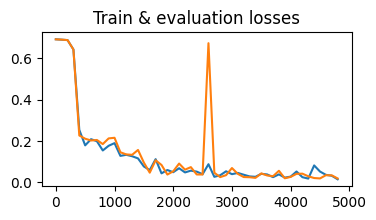

In [52]:
showPlot(train_losses, val_losses, param.epochs,param.log_interval,'Train & evaluation losses')

# Валидация

In [111]:
x_test, y_test = generator(1)
x_test = torch.tensor(x_test).permute(0,3,2,1).float().to(device)
y_test = torch.tensor(y_test).permute(0,3,2,1).long().to(device)[:,1,:,:]
output_best = model_best(x_test)
image, mask, predicted = x_test[0],  y_test[0], output_best[0,1]

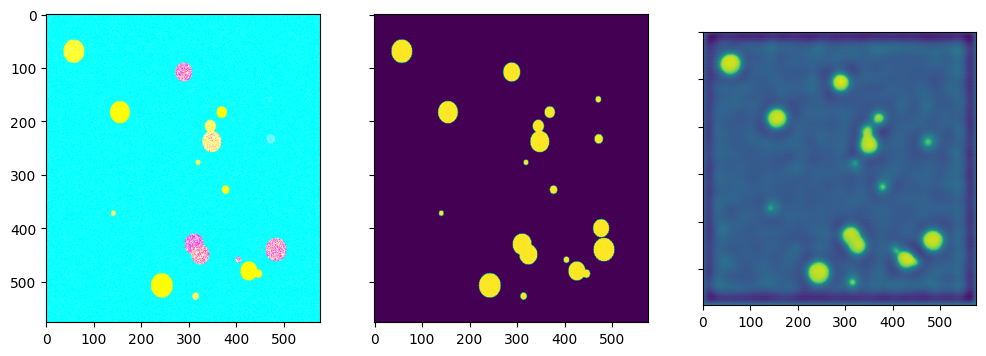

In [112]:
fig, ax = plt.subplots(1,3, sharey=True, figsize=(12,4))

ax[0].imshow(image.permute(1,2,0).cpu(), aspect="auto")
ax[1].imshow(mask.cpu(), aspect="auto")
ax[2].imshow(predicted.detach().cpu())
